# Batch Normalization, lightning, логгирование экспериментов

Цель этого ноутбука -- знакомство с фреймворком PyTorch Lightning, который предназначен для автоматизации и упрощения использования PyTorch

 План семинара:

* BatchNormalization
* PyTorch Lightning
* Loggers

In [1]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from PIL import Image

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [2]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cpu


## 1. [Batch Normalization (BN)](http://arxiv.org/abs/1502.03167)

Идея batch normalization на самом деле содержится в самом названии &mdash;
**будем нормализовать выход каждого слоя**: вычитать из значения каждого признака
среднее его значение по текущему батчу и делить на стандартное отклонение. После этого значения признаков умножаются на обучаемый параметр `gamma` и прибавляется обучаемый свободный член `beta`, что позволяет "контролировать" среднее значение и дисперсию признаков.

*Forward pass:*

$$
x \in \mathbb{R}^{n \times d}
$$
$$
\mu, \sigma, \gamma, \beta \in \mathbb{R}^{1 \times d}
$$

В фазе обучения  (`self.training == True`) BatchNormalization слой делает то, что описано выше:

$$
\text{BatchNormalization}(x) = \gamma \left( \frac{x - \mu}{\sqrt{\sigma + \varepsilon}} \right) + \beta
$$

$$
\text{BatchNormalization}(x) \in \mathbb{R}^{n \times d}
$$

где
* $\mu$ и $\sigma$ &mdash; среднее и дисперсия значений признаков в $x$,
* $\varepsilon$ нужен чтобы избежать деление на машинный 0,
* $\gamma$ и $\beta$ &mdash; обучаемые параметры.

Также в фазе обучения среднее и дисперсию признаков обновляют (moving average):

```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```

В фазе применения нейросети (`self.training == False`) слой нормализует вход `input`, используя посчитанные в фазе обучения `moving_mean` и `moving_variance`.

На практике BatchNorm обычно ускоряет сходимость при оптимизации, то есть позволяет обучать нейросети быстрее. Но, как обычно в нейронных сетях, эффективность нужно проверять на практике.

## 2. Lightning

Полезные ссылки:

[Docs](https://lightning.ai/docs/pytorch/stable/starter/installation.html)

[Lightning Universe](https://github.com/Lightning-Universe) (Комьюнити проекты, расширения и доп возможности)

[Lightning Flash](https://github.com/Lightning-Universe/lightning-flash) (Зоопарк готовых моделей)

[Lightning Bolts](https://lightning-bolts.readthedocs.io/en/latest/) (Еще один зоопарк моделей, датасетов и супер-коллбеков)

[Train model with billions of parameters](https://lightning.ai/docs/pytorch/stable/advanced/model_parallel.html)


### Intro

Мир обучения нейронок уже давно перешагнул за `train_loop(...)`, `optimizer.step()`, ..., `zero_grad`, ...,
и ровно как вы не дергаете Cuda из питона и не пишите полносвязные слои руками, ровно так же не стоит писать тренировку модели руками, потому что:
- Это долго
- Это баговано
- Каждый раз одно и то же
- Множество вещей вы просто не знаете как написать (и это нормально!)
- Поддерживать простыню кода в тысячи сток просто невозможно, если вы не мазохист
- Процесс добавления распределенного обучения для вас станет последней ступенью ада

Есть несколько фреймворков, которые решают перечисленные выше проблемы. Это Catalyst, PyTorch Lightning, PyTorch Ignite.

Далее речь пойдет именно о Lightning.

### Установка

[Installation Guide](https://lightning.ai/docs/pytorch/stable/starter/installation.html)

```bash
# Pip
python -m pip install lightning

# Conda
conda install lightning -c conda-forge
```

### Основные возможности

Как уже было сказано выше, цель данного фреймворка избавить от необходимости написания лишнего кода. 

- **Тренировка и Валидация**: Lightning автоматизирует переключение между тренировочным и валидационным режимами (а так же test и predict режимы), контролирует циклы обучения, и предоставляет полезные коллбеки(способ модифицировать цикл обучения/валидации или тестирования добавлением нескольких строк кода, более подробно рассмотрим далее).
- **GPU и TPU**: Lightning обеспечивает простое управление ресурсами, автоматизируя развертывание модели на доступные устройства (GPUs/TPUs).
- **Масштабирование**: с легкостью (реально одной строчкой) можно использовать режимы распределенного обучения (и даже инференса)
- **Модульность и переиспользуемость**:
    - `LightningModule`: Объединяет в себе модель, оптимизатор и логику тренировочного цикла. Может быть использован для предсказаний, а также сохранен и загружен без проблем.
    - `Callbacks`: Позволяют встраивать дополнительную логику в тренировочный цикл без изменения исходного кода модели. А так же есть зоопарк коробчных и сторонних колбеков, отвечающих практически за всю логику, которую вам захочется добавить
- **Разделение логики**:
    - Research vs Engineering: Lightning позволяет разработчикам сосредотачиваться на исследовательской части работы, выделяя логику тренировочного цикла и обработку данных в отдельные абстракции.
- **Совместимость и Интеграция**:
    - `LightningModule`: наследуется от torch.nn.Module. Lightning предоставляет естественный переход от стандартного кода PyTorch, позволяя легко адаптировать существующий код.
    - Совместимость с библиотеками: Обширная поддержка различных библиотек и фреймворков для логирования, визуализации и др.
- **Безопасность и Отказоустойчивость**:
    - Остановка и Возобновление: Возможность остановки обучения и последующего возобновления с того же места.
    - Очистка: Автоматическое освобождение ресурсов GPU после тренировки.

### Логгирование экспериментов

- Логгер (или их список) передается напрямую в `pl.Trainer`
- В логгер можно писать через `self.log()` внутри Lightning модулей
- Так же в логгер пишут дополнительные коллбеки и плагины, которые вы передаете в `pl.Trainer`
- Некоторые из готовых логгеров:
    - [CSV Logger](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.csv_logs.html#module-lightning.pytorch.loggers.csv_logs)
    - [Mlflow Logger](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.mlflow.html#module-lightning.pytorch.loggers.mlflow)
    - [Tensorboard Logger](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html#module-lightning.pytorch.loggers.tensorboard)
    - [Wandb Logger](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.wandb.html#module-lightning.pytorch.loggers.wandb)

### Callbacks

- Коллбеки передатся в `pl.Trainer` и позволяют выполнить какое-то действие в конкретный момент процесса обучения, не изменяя исходный код модели.
- Пользователь может создавать собственные коллбеки, отнаследовавшись от базового `Callback` класса и переписав его методы.
- Некоторые полезные коллбеки, которые встроены в Lightning:
    - `ModelCheckpoint`: автоматически сохраняет чекпоинты модели в процессе обучения
    - `EarlyStopping`: останавливает обучение, когда заданная метрика перестает улучшаться
    - `LearningRateMonitor`: сохраняет значения скорости обучения в логгер

Посмотрим как это всё работает на практике, обучив немного модифицированную нейронную сеть с прошлого занятия.

Загружаем данные: 

In [3]:
# Часть данных для обучения
train_dataset = torchvision.datasets.CIFAR10(root='./cifar', download=True, train=True, transform=transforms.ToTensor())

# Валидационная / тестовая часть данных
val_dataset = torchvision.datasets.CIFAR10(root='./cifar', download=True, train=False, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на несколько картинок из обучающей выборки:

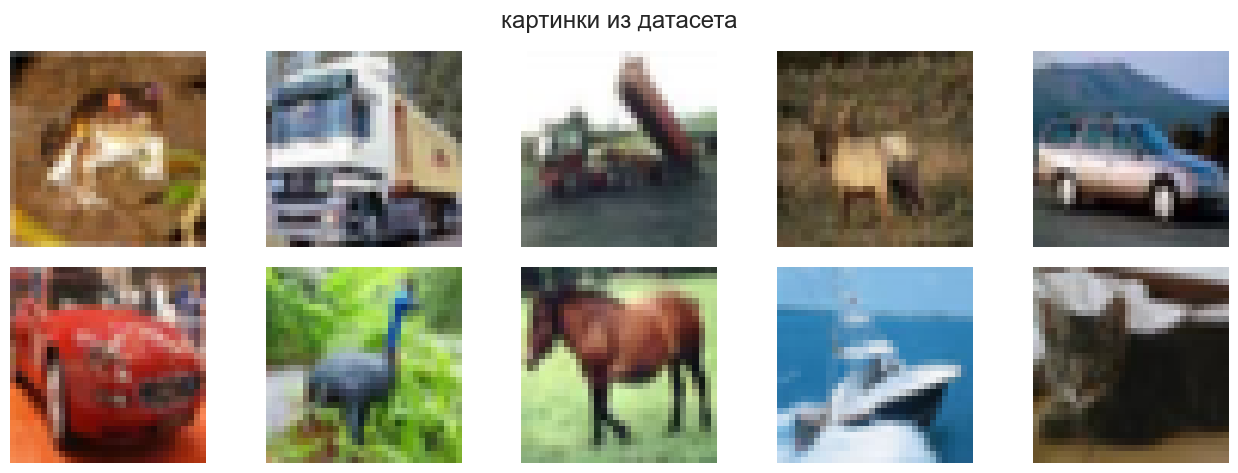

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(13, 5))

for i in range(10):
    axs[i // 5, i % 5].imshow(train_dataset[i][0].permute((1, 2, 0)))
    axs[i // 5, i % 5].axis('off')

plt.suptitle('картинки из датасета', y=0.95)
plt.tight_layout()

Создадим даталоадеры:

In [5]:
batch_size = 512

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)

Зададим базовый класс модели:

In [6]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

Теперь начнем использовать преимущества Lightning:

In [7]:
import lightning.pytorch as pl
from torchmetrics.functional import accuracy
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

In [8]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=10):
        super().__init__()
        
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = MySimpleModel()
    
    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

### Logging

Рассмотрим логгирование более подробно. Разберем логгирование с помощью Tensorboard и MLFlow.

Tensorboard является частью Tensorflow, но является отдельным пакетом. Лучше всего подходит для локального логгирования. Он способен:
- Отслеживать и визуализировать метрики, например loss и accuracy.
- Визуализировать вычислительный граф (параметры и слои).
- Просматривать гистограммы весов, сдвигов и то, как они меняются со временем.
- Строить проекции промежуточных представлений в пространства с более низкой размерностью
- Отображать картинки, текст, аудиоданные.

MLFLow - open source MLOps платформа. Основные возможности:

- Отслеживание экспериментов: код, данные, параметры, результаты
- Проекты: позволяет запаковать data science код для воспроизведения на любой платформе
- Модели: позволяет деплоить модели на сервер
- Model registry: позволяет хранить, описывать и управлять моделями с центральном репозитории

**Установка**

```bash
# Tensorboard
pip install tensorboard

# MLFlow
pip install mlflow
```

**Полезные ссылки:**

[MLFlow](https://mlflow.org) - сайт MLFlow, на котором можно почитать про примеры применения, посмотреть как get started guide, так и полную документацию

[Tensorboard](https://www.tensorflow.org/tensorboard/get_started) - Гайд по Tensorboard

[Lightning logging](https://lightning.ai/docs/pytorch/stable/extensions/logging.html) - Логгирование в lightning

In [9]:
# Инициализация логгеров
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

Инициализируем модель. С помощью `ModelCheckpoint` можно периодически сохранять модель / выполнять callback, отслеживая некоторую величину. Показателем того, что модель стала лучше (параметр `monitor`), может быть любая метрика, сохраненная с помощью `log()` или `log_dict()`.

In [10]:
# инициализируем модель
simple_model = MySimpleModelLightning()

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')
# Создаем мониторинг ресурсов
device_stats = DeviceStatsMonitor()
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

Можно задать свою функцию callback, которая наследуется от `pytorch_lightning.callbacks.Callback`. Можно после прогона батча на валидации дополнительно сохранять какие-то данные, например, предсказания модели. Здесь мы логируем 20 картинок и предсказания для них.

Создаем Trainer: нужно указать логгер, все функции callback, ускоритель и количество эпох.

In [11]:
trainer = pl.Trainer(
    logger=tb_logger,                    
    callbacks=[
        checkpoint_callback,
        # early_stopping,
        device_stats
    ],
    accelerator="cpu",
    max_epochs=30,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Осталось обучить модель с помощью `train.fit`. Видим, как нам не нужно отдельно прописывать функцию обучения &mdash; Pytorch Lightning сделал это за нас. Также видим статистику по параметрам нашей модели.

In [12]:
trainer.fit(simple_model, train_batch_gen, val_batch_gen)


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | MySimpleModel    | 803 K  | train
-------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.17it/s]

c:\Users\korot\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\korot\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\korot\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s, v_num=0]


In [57]:
# Интерактивный просмотр логов
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/lightning_logs/version_0/

Reusing TensorBoard on port 6008 (pid 6044), started 0:00:02 ago. (Use '!kill 6044' to kill it.)

### Задание 2

Добавьте слои BatchNorm и Dropout в нейронную сеть там, где это необходимо, проведите минимум 3 эксперимента по обучению модели с использованием PyTorch Lightning и Tensorboard с разными параметрами (например можно изменить learning rate, число нейронов на скрытом слое, оптимизатор, вероятность отключения нейронов на слое, размер батча). Как изменения повлияли на скорость обучения и финальное качество модели? Сделайте выводы.

При сдаче задания вместе с ноутбуком прикрепите заархивированную папку с логами tensorboard

#### Model 1

In [17]:
class Model_1_Dropout(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(Model_1_Dropout, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.dropout = nn.Dropout(0.4)
        self.linear2 = nn.Linear(256, 64)
        self.dropout = nn.Dropout(0.4)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [18]:
class Model_1_Dropout_Lightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=10):
        super().__init__()
        
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = Model_1_Dropout()
    
    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [19]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

model = Model_1_Dropout_Lightning()

In [20]:
trainer = pl.Trainer(
    logger=tb_logger,                    
    callbacks=[
        ModelCheckpoint(monitor='val_accuracy', mode='max'),
        EarlyStopping('val_loss'),
        DeviceStatsMonitor(),
    ],
    accelerator="cpu",
    max_epochs=30,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, train_batch_gen, val_batch_gen)


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | Model_1_Dropout  | 803 K  | train
-------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 21: 100%|██████████| 98/98 [00:09<00:00, 10.48it/s, v_num=1]          


In [58]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/lightning_logs/version_1/

Reusing TensorBoard on port 6008 (pid 28000), started 1:04:12 ago. (Use '!kill 28000' to kill it.)

#### Model 2

In [23]:
class Model_2_BatchNorm(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(Model_2_BatchNorm, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [24]:
class Model_2_BatchNorm_Lightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=10):
        super().__init__()
        
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = Model_2_BatchNorm()
    
    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [25]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

model = Model_2_BatchNorm_Lightning()

In [26]:
trainer = pl.Trainer(
    logger=tb_logger,                    
    callbacks=[
        ModelCheckpoint(monitor='val_accuracy', mode='max'),
        EarlyStopping('val_loss'),
        DeviceStatsMonitor(),
    ],
    accelerator="cpu",
    max_epochs=30,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model, train_batch_gen, val_batch_gen)


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | CrossEntropyLoss  | 0      | train
1 | model     | Model_2_BatchNorm | 803 K  | train
--------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 20: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s, v_num=2]         


In [36]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/lightning_logs/version_2

Reusing TensorBoard on port 6006 (pid 42620), started 0:02:41 ago. (Use '!kill 42620' to kill it.)

#### Model 3

In [29]:
class Model_3(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(Model_3, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [30]:
class Model_3_Lightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=10):
        super().__init__()
        
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = Model_3()
    
    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [31]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

model = Model_3_Lightning()

In [32]:
trainer = pl.Trainer(
    logger=tb_logger,                    
    callbacks=[
        ModelCheckpoint(monitor='val_accuracy', mode='max'),
        EarlyStopping('val_loss'),
        DeviceStatsMonitor(),
    ],
    accelerator="cpu",
    max_epochs=30,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model, train_batch_gen, val_batch_gen)


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | Model_3          | 803 K  | train
-------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s, v_num=3]          


In [35]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/lightning_logs/version_3

Reusing TensorBoard on port 6016 (pid 11312), started 0:34:49 ago. (Use '!kill 11312' to kill it.)